In [1]:
import sympy
import numpy             as np
import matplotlib.pyplot as plt

from sympy                    import *

# Introduction

In this script we solve the expansion equation as described in section 5 of the summary for the case of the Schwarzschild metric under the assumption of symmetry in $\phi$. The solving procedure is similar to the one in the case of $\theta$-symmetry, except that we're dealing with a different equation, and that we can no longer use periodic boundary conditions (see below). The equation to be solved can again be obtained via the symbolic solver in "AppHor_conformal.ipynb". For now we separate the linear part by hand and we obtain
\begin{equation}
    A \cdot h = S(h) \quad \Leftrightarrow \quad 4M\frac{d^2h}{d\theta^2} + 4M\cot{\theta}\frac{dh}{d\theta} - 16h = -8h\frac{d^2h}{d\theta^2} - \frac{\cot{\theta}}{h^2}(4M+8h)\left(\frac{dh}{d\theta}\right)^3 - \left(\frac{4M}{h}-24\right) \left(\frac{dh}{d\theta}\right)^2 - 8h\cot{\theta}\frac{dh}{d\theta} - 8M
\end{equation}
We no longer have periodic boundary conditions in this case. Instead we require at the boundaries $\theta = 0$ and $\theta = 2\pi$ that the derivative of $h$ with respect to $\theta$ be zero. This ensures that, when rotating the solution over all $\phi$-values, there's no discontinuity at the poles (i.e. no kink points).
What remains to explain is how this condition influences the structure of the tridiagonal matrix corresponding to the linear part. For a general $i$, the equation is simply
\begin{equation}
    $h[i] \quad \rightarrow \quad \frac{4M}{(\Delta\theta)^2} \left(h[i+1]-2h[i]+h[i-1]\right) + \frac{2M}{\Delta\theta} \cot{(\theta[i])}\left(h[i+1]-h[i-1]\right) - 16h[i]
\end{equation}
However, we can no longer use this for $i=0,N_{\theta}$ (no periodicity). Instead we expand $h[1]$ around $h[0]$ (on the top pole) as
\begin{equation}
    h[1] = h[0] + \Delta\theta \frac{dh}{d\theta}\Bigg|_{0} + \frac{1}{2} (\Delta\theta)^2 \frac{d^2h}{d\theta^2}\Bigg|_{0} = h[0] + \frac{1}{2} (\Delta\theta)^2 \frac{d^2h}{d\theta^2}\Bigg|_{0}
\end{equation}
where we used $\frac{dh}{d\theta}\Big|_{0} = 0$ at the pole. Now we can use the original expansion equation to replace $\frac{d^2h}{d\theta^2}\Big|_{0}$ and obtain
\begin{equation}
    h[1] = h[0] + \frac{1}{2} (\Delta\theta)^2 \frac{1}{4M} \left(S + 16h[0]\right) \quad \Leftrightarrow \quad \frac{8M}{(\Delta\theta)^2} (h[1]-h[0]) - 16h[0] = S
\end{equation}
This last equation gives a relation for $h[0]$ in terms of $h[1]$ and so it shows what the first row of the tridiagonal matrix should look like. A entirely analogous computation holds for the last element of $h$, i.e. the last row.

All the required components (tridiagonal matrix for linear part, non-linear right-hand-side, ...) are constructed in the functions below, as well as the iterative solver.

In [2]:
'''
Define finite differences (central scheme)
'''


def der(h, delta, i):
    if (i == 0) or (i == len(h)-1):   # zero derivative on poles
        return 0
    else:
        return ((h[i+1] - h[i-1]) / (2*delta))

def der2(h, delta, i):
    if i == 0:
        return ((h[i] - 2*h[i+1] + h[i+2]) / delta**2)   # forward derivative on theta = 0
    elif i == len(h)-1:
        return ((h[i] - 2*h[i-1] + h[i-2]) / delta**2)   # backward derivative on theta = pi
    else:
        return ((h[i+1] - 2*h[i] + h[i-1]) / delta**2)



'''
Function which calculates RHS of equation
'''

def rhs_update(h, delta):
    rhs = np.zeros(N_th)
    for i in range(N_th):
        rhs[i] = -8*h[i] * der2(h, delta, i) - cot_th[i]/h[i]**2 * (8+8*h[i])*(der(h, delta, i))**3 - (8/h[i] - 24) * (der(h, delta, i))**2 - 8*h[i]*cot_th[i] * der(h, delta, i) - 16
    return rhs



'''
Construct tridiagonal matrix for the linear LHS
'''

def tridiag(n, delta, cot_th):
    main_diag = -16 - 16/delta**2 * np.ones(n)
    upper_diag = 8/delta**2 + 4*cot_th[:-1]/delta
    lower_diag = 8/delta**2 - 4*cot_th[1:]/delta
    
    tridiagonal = np.diag(main_diag) + np.diag(upper_diag, k=1) + np.diag(lower_diag, k=-1)

    tridiagonal[0,1] = 16/delta**2     # first row separate element (see calculation above)
    tridiagonal[-1,-2] = 16/delta**2   # last row separate element
    
    return tridiagonal

In [7]:
'''
Initialize data
'''
# Initialize data
N_th = 20
theta = np.linspace(0, np.pi, N_th)
delta = theta[1] - theta[0]

cot_th = 1 / np.tan(theta[1:N_th-1])
cot_th = np.insert(cot_th, 0, 0)       # insert zero to avoid singularity (possible because dh/dtheta is zero on poles anyway)
cot_th = np.insert(cot_th, -1, 0)      # insert zero to avoid singularity

#h = 0.1*np.sin(3*theta) + np.ones(N_th)
h = 0.7*np.ones(N_th)



'''
Function which solves the system for h iteratively
'''

def solve_h(h, delta, m, n):
    h_new = h
    differences = []
    for i in range(n):
        rhs = rhs_update(h_new, delta)   # calculate rhs (i.e. S(h))
        h_old = h_new                    # keep track of previous h
        h_new = np.linalg.solve(m, rhs)  # solve h_new = m^(-1) * rhs
        diff = sum((h_new[i] - h_old[i])**2 for i in range(len(h)))
        differences.append(diff)
    return h_new, differences



n_iter = 5

m = tridiag(N_th, delta, cot_th)

sol_h, differences = solve_h(h, delta, m, n_iter)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


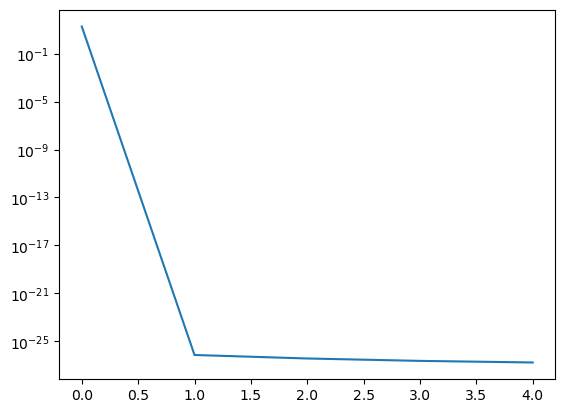

In [6]:
print(sol_h)
plt.plot(differences);
plt.yscale('log')

Condition Number of m: 18.828505365549628
1.6295812881537473e+20


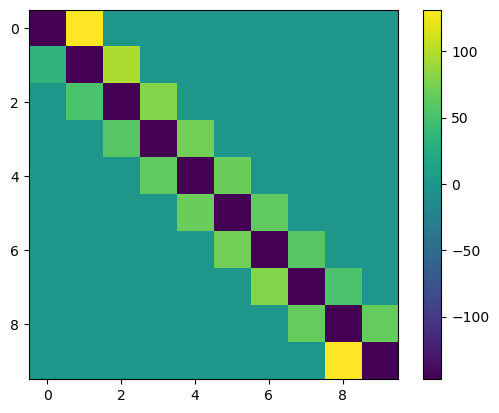

In [11]:
'''
Representation of tridiagonal matrix
+ calculates condition number and determinant
'''

plt.imshow(m)
plt.colorbar()
condition_number = np.linalg.cond(m)
print(f"Condition Number of m: {condition_number}")
det = np.linalg.det(m)
print(f"Determinant of m: {det}")

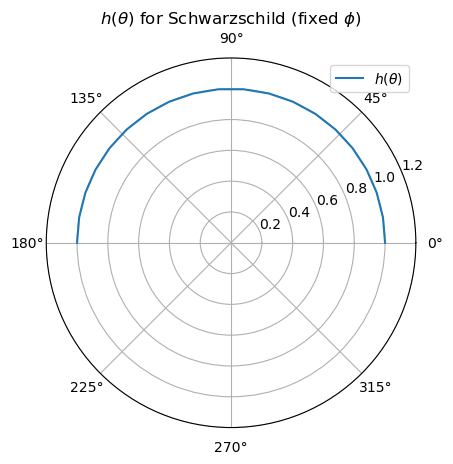

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, sol_h, label=r"$h(\theta)$")
ax.set_rmax(1.2)
ax.grid(True)
ax.legend(loc='upper right')
plt.title(r"$h(\theta)$ for Schwarzschild (fixed $\phi$)")
plt.show()